# Machine learning to segment neutron images


<p style="font-size:1.75em;padding-bottom: 1.0em;"><b>Machine learning to segment neutron images</b></p>
<p style="font-size:1.2em;padding-bottom: 0.25em;">Anders Kaestner, Beamline scientist - Neutron Imaging</p>  
<p style="font-size:1.2em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

# Lecture outline

In this lecture about machine learning to segment neutron images we will cover the following topics

1. Introduction
2. Limited data problem
3. Unsupervised segmentation
4. Supervised segmentation
5. Final problem: Segmenting root networks using convolutional NNs
6. Future Machine learning challenges in NI

## Importing needed modules
This lecture needs some modules to run. We import all of them here.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.filters as flt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

# Introduction

- Introduction to neutron imaging
  - Some words about the method
  - Contrasts
  
- Introduction to segmentation
  - What is segmentation
  - Noise and SNR
  
- Problematic segmentation tasks
  - Intro
  - Segmenation problems in neutron imaging
  


## What is an image?

----

A very abstract definition: 
- __A pairing between spatial information (position)__
- __and some other kind of information (value).__

In most cases this is a two- or three-dimensional position (x,y,z coordinates) and a numeric value (intensity)



## Science and Imaging
Images are great for qualitative analyses since our brains can quickly interpret them without large _programming_ investements.
### Proper processing and quantitative analysis is however much more difficult with images.
 - If you measure a temperature, quantitative analysis is easy, $50K$.
 - If you measure an image it is much more difficult and much more prone to mistakes, subtle setup variations, and confusing analyses


### Furthermore in image processing there is a plethora of tools available

- Thousands of algorithms available
- Thousands of tools
- Many images require multi-step processing
- Experimenting is time-consuming

## Some word about neutron imaging

Neutron imaging is a method based on transmission of the neutron radiation through a sample, i.e. the fundamental information is a radiograph. In this sense it is very much similar to the more known x-ray imaging. The intensity in a radiographic image proportional to the amount of radiation that remains after it was transmitted through the sample. The transmitted radiation is described by Beer-Lambert's law which in its basic form look like

$I=I_0\cdot{}e^{-\int_L \mu{}(x) dx}$

Where $\mu(x)$ is the attenuation coefficient of the sample at position _x_.

Single radiographs are relatively rare. In most experiments the radiographs are part of a time series aquisition or projections for the 3D tomography reconstuction. In this lecture we are not going very much into the details about the imaging method as such. This is a topic for other schools that are offered. 


## Neutron imaging contrast

## Measurements are rarely perfect
<figure><img src="figures/imperfect_imaging_system.svg" style="height:400px" align="middle"></figure>

There is no measurement that is perfect. This is also true for neutron imaging. The ideal image is the sample is distorted for many reasons. The figure below shows how an image of a sample can look after passing though the acquisition system. These quailty degradations will have an impact on the analysis of the image data. In some cases, it is possible to correct for some of these artifacts using classing image processing techniques. There are however also cases that require extra effort to correct the artifacts.  
![](figures/imperfect_imaging_system.pdf)

### Factors affecting the image quality

The list below provides some factors that affect the quality of the acquired images. Most of them can be handled by changing the imaging configuration in some sense. It can however be that the sample or process observed put limitiations on how much the acquisition can be tuned to obtain the perfect image.

* Resolution (Imaging system transfer functions)
* Noise
* Contrast
* Inhomogeneous contrast
* Artifacts

#### Resolution
The resolution is primarily determined optical transfer function of the imaging system. The actual resolution is given by the extents of the sample and how much the detector needs to capture in one image. This gives the field of view and given the number pixels in the used detector it is possible to calculate the pixel size. The pixel size limits the size of the smallest feature in the image that can be detected. The scintillator, which is used to convert neutrons into visible light, is chosen to 
1. match the sampling rate given by the pixel size.
2. provide sufficient neutron capture to obtain sufficient light output for a given exposure time.

#### Noise
An imaging system has many noise sources, each with its own distribution e.g.
1. Neutron statistics - how many neutrons are collected in a pixel. This noise is Poisson distributed. 
2. Photon statistics - how many photons are produced by each neutron. This noise is also Poisson distributed.
3. Thermal noise from the electronics which has a Gaussian distribution.
4. Digitation noise from converting the charges collected for the photons into digital numbers that can be transfered and stored by a computer, this noise has a binominal distribution.

The neutron statistics are mostly dominant in neutron imaging but in some cases it could also be that the photon statistics play a role. 

#### Contrast
The contrast in the sample is a consequence of 
1. how well the sample transmits the chosen radiation type. For neutrons you obtain good contrast from materials containing hydrogen or lithium while many metals are more transparent.
2. the amount of a specific element or material represented in a unit cell, e.g. a pixel (radiograph) or a voxel (tomography). 

The objective of many experiments is to quantify the amount of a specific material. This could for example be the amount of water in a porous medium.

Good contrast between different image features is important if you want to segment them to make conclusions about the image content. Therefore, the radiation type should be chosen to provide the best contrast between the features.

#### Inhomogeneous contrast
The contrast in the raw radiograph depends much on the beam profile. These variations are easily corrected by normalizing the images by an open beam or flat field image. 

- __Biases introduced by scattering__ Scattering is the dominant interaction for many materials use in neutron imaging. This means that neutrons that are not passing straight though the sample are scattered and contribute to a background cloud of neutrons that build up a bias of neutron that are also detected and contribute to the 

- __Biases from beam hardening__ is a problem that is more present in x-ray imaging and is caused by that fact that the attenuation coefficient depends on the energy of the radiation. Higher energies have lower attenuation coefficient, thus will high energies penetrate the thicker samples than lower energies. This can be seen when a polychromatic beam is used. 

#### Artifacts
Many images suffer from outliers caused by stray rays hitting the detector. Typical artefacts in tomography data are
- Lines, which are caused by outlier spots that only appear in single projections. These spot appear as lines in the reconstructed images.
- Rings are caused by stuck pixels which have the same value in a projections.

## Introduction to segmentation
What is segmentation

### Basic segmentation: Applying a threshold to an image
Start out with a simple image of a cross with added noise

$$ I(x,y) = f(x,y) $$

Here, we create a test image with two features embedded in uniform noise; a cross with values in the order of '1' and background with values in the order '0'. The figure below shows the image and its histogram. The histogram helps us to see how the graylevels are distributed which helps to decide where to put a threshold that segments the cross from the background.

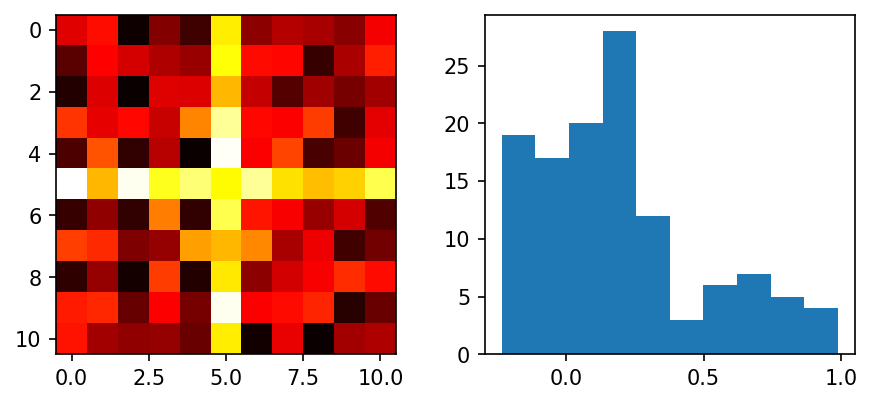

In [16]:
fig,ax = plt.subplots(1,2,figsize=(7,3))
nx = 5; ny = 5;
xx, yy = np.meshgrid(np.arange(-nx, nx+1)/nx*2*np.pi, 
                     np.arange(-ny, ny+1)/ny*2*np.pi)
cross_im =   1.5*np.abs(np.cos(xx*yy))/(np.abs(xx*yy)+(3*np.pi/nx)) + np.random.uniform(-0.25, 0.25, size = xx.shape)
im=ax[0].imshow(cross_im, cmap = 'hot'); 
ax[1].hist(cross_im.ravel(),bins=10);

### Applying a threshold to an image

By examining the image and probability distribution function, we can _deduce_ that the underyling model is a whitish phase that makes up the cross and the darkish background

Applying the threshold is a deceptively simple operation

$$ I(x,y) = 
\begin{cases}
1, & f(x,y)\geq0.40 \\
0, & f(x,y)<0.40
\end{cases}$$


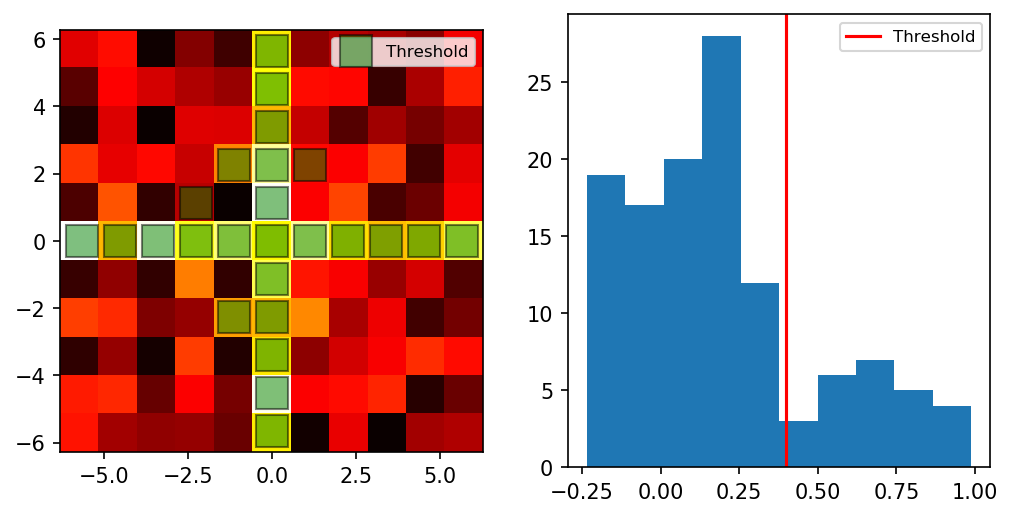

In [17]:
threshold = 0.4; thresh_img = cross_im > threshold

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(cross_im, cmap = 'hot', extent = [xx.min(), xx.max(), yy.min(), yy.max()])
ax[0].plot(xx[np.where(thresh_img)]*0.9, yy[np.where(thresh_img)]*0.9,
           'ks', markerfacecolor = 'green', alpha = 0.5,label = 'Threshold', markersize = 15); ax[0].legend(fontsize=8);
ax[1].hist(cross_im.ravel(),bins=10); ax[1].axvline(x=threshold,color='r',label='Threshold'); ax[1].legend(fontsize=8);

## Noise and SNR

## Problematic segmentation tasks
Intro

## Segmenation problems in neutron imaging

# Limited data problem

## Training data from NI is limited

## Augmentation

## Transfer learning

# Unsupervised segmentation
-	e.g. k-means

# Supervised segmentation
-	e.g. k-NN, decision trees
-	NNs for segmentation

## Example - Detecting and correcting unwanted outliers (a.k.a. spots) in neutron images

### Training data
We have two choices:
1. Use real data
    - requires time consuming markup to provide training data
    - corresponds to real life images
2. Synthesize data
    - flexible and provides both 'dirty' data and ground truth.
    - model may not behave as real data

### Baseline - Traditional spot cleaning algorithm

<figure><img src="figures/spotclean_algorithm.svg" style="height:400px" align="middle"></figure>

__Parameters__

- _N_ Width of median filter.
- _k_ Threshold level for outlier detection.

### The spot cleaning algorithm

The baseline algorithm is here implemented as a python function that we will use when we compare the performance of the CNN algorithm. This is the most trivial algorithm for spot cleaning and there are plenty other algorithms to solve this task.  

In [18]:
def spotCleaner(img, threshold=0.95, wsize=3) :
    mimg = flt.median(img,size=(wsize,wsize))
    timg = np.abs(img-mimg) < threshold
    
    cleaned = img * timg + mimg * (1-timg)
    
    return cleaned

### Build a CNN for spot detection and cleaning

### Performance evaluation
Any analysis system must be verified

For this we need to split our data into three categories:
1. Training data
2. Test data
3. Validation data

#### Compare results using ROC curve

# Final problem: Segmenting root networks in the rhizosphere using convolutional NNs
-	Problem definition
-	NN model
-	Loss functions
-	Training
-	Results

# Future Machine learning challenges in neutron imaging